# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

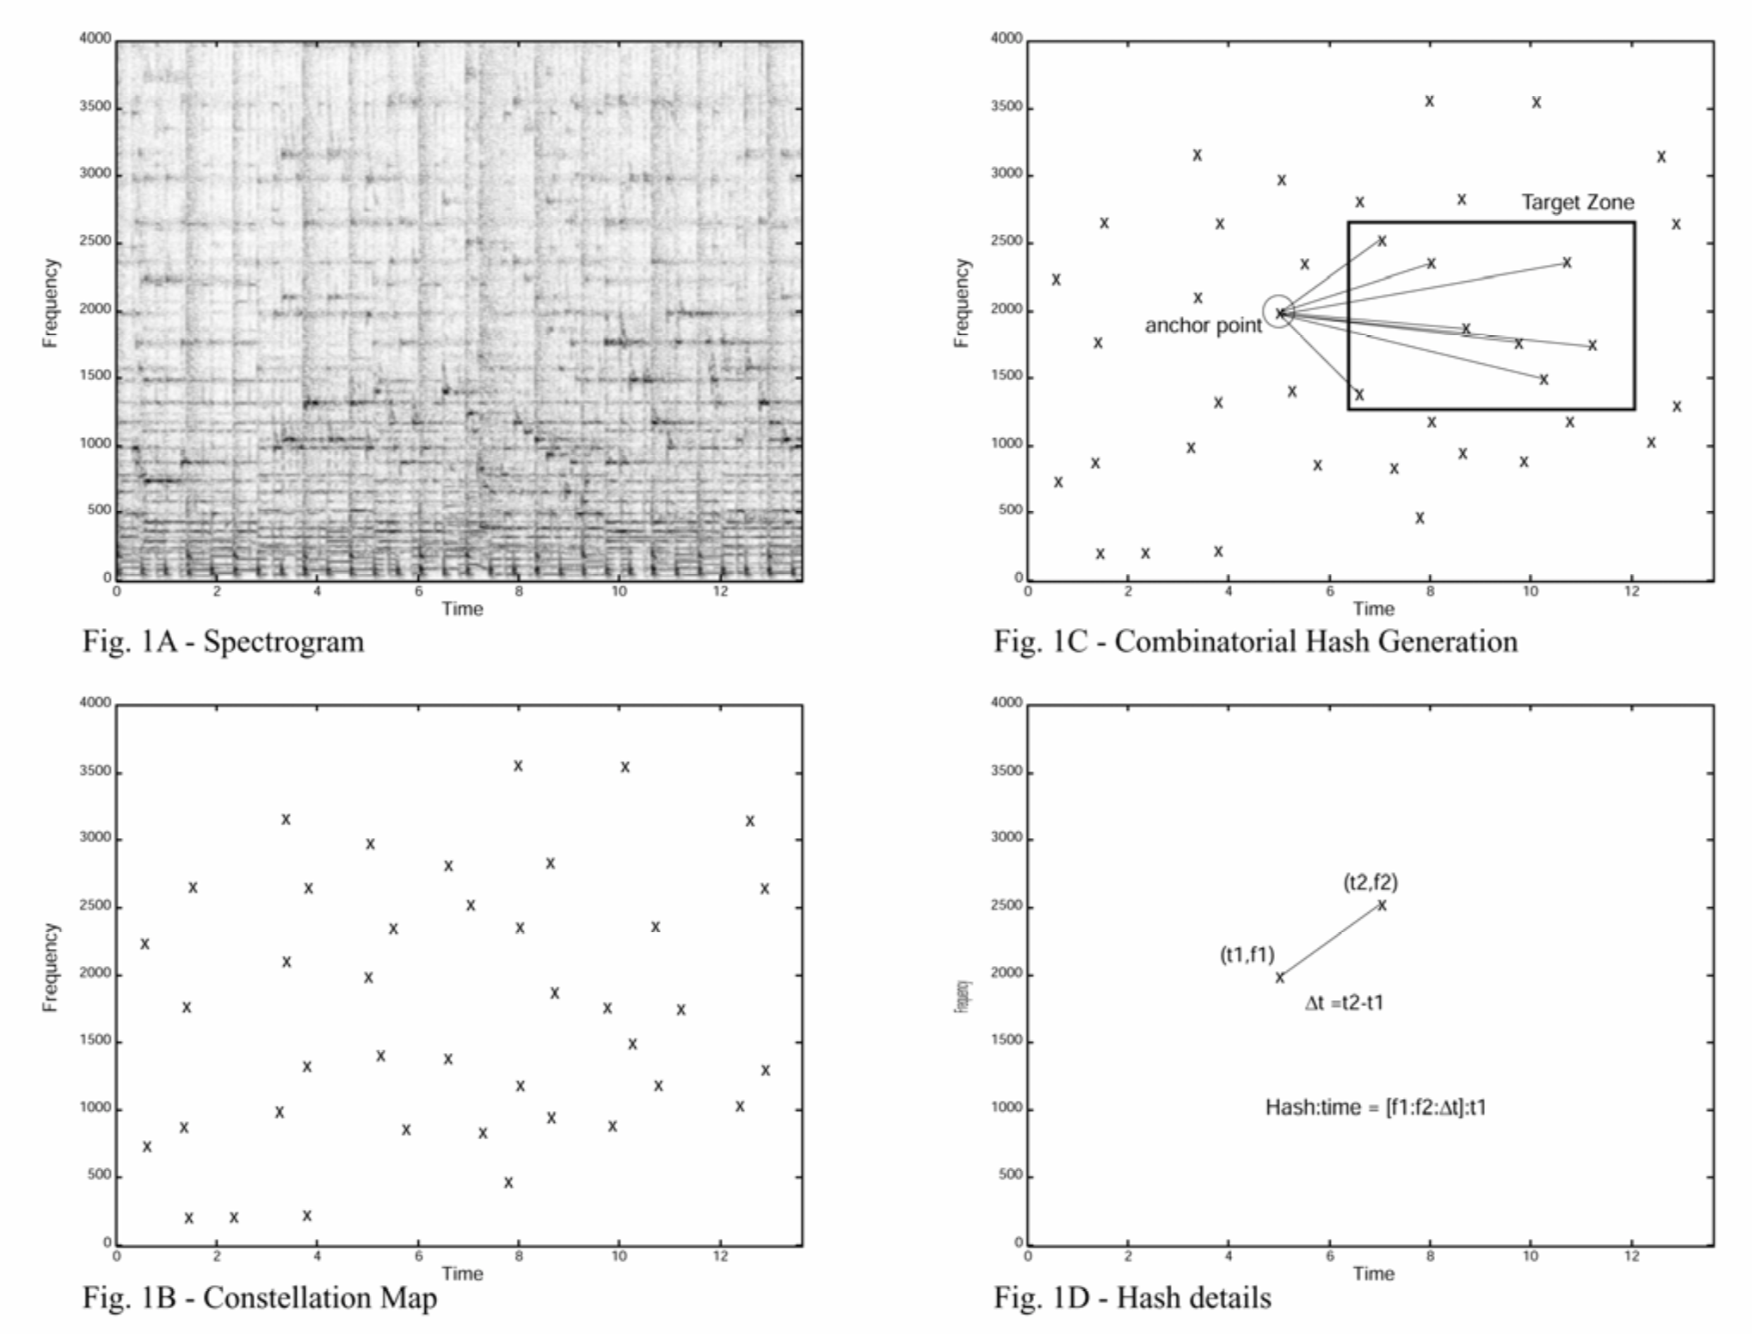

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


In [543]:
# path to queries
path_to_queries = '../../data/queries/'

We listened to Q1.wav and we really liked it. We decided to use it for our fingerprinting system. Also, after some reverse-engineering, it looks like the one Bob is using. That's a good cure against learned helplessness. The code for this is below.

In [544]:
import librosa

# load Q1.wav
y, sr = librosa.load(path_to_queries + 'Q1.wav', sr=None)

(442330,)

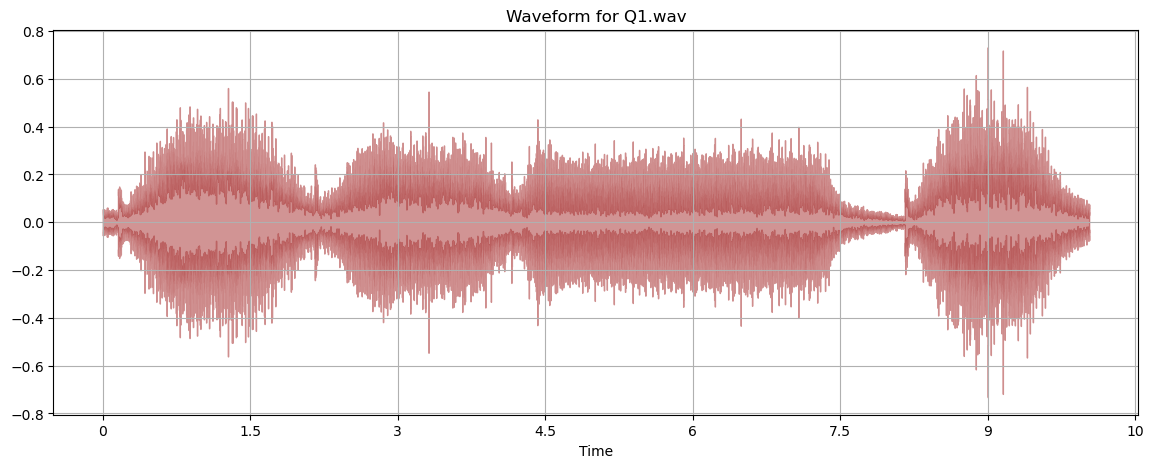

In [545]:
import matplotlib.pyplot as plt
import librosa.display

# plot the waveform
plt.figure(figsize=(14, 5))
plt.grid()
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='brown')
plt.title('Waveform for Q1.wav')

# Use this cool method 'shape' on sound 'y' to get the number of samples
y.shape

Now we plot the spectogram.

First, we specify the parameters as given in the assignment.

> 'Zeropadding four times the length of the window'

We think this means to make the n_fft to be 4 times the win_length, so that's what we do.

In [546]:
# win length of 50ms, hop length of 10ms
from scipy import signal

# 'Zeropadding four times the length of the window'
# I think this means to make the n_fft to be 4 times the win_length

n_fft = 2**13
win_length = int(0.05 * sr)
hop_length = int(0.01 * sr)

Finally, we compute and plot the spectogram.

Text(0, 0.5, 'Frequency (Hz)')

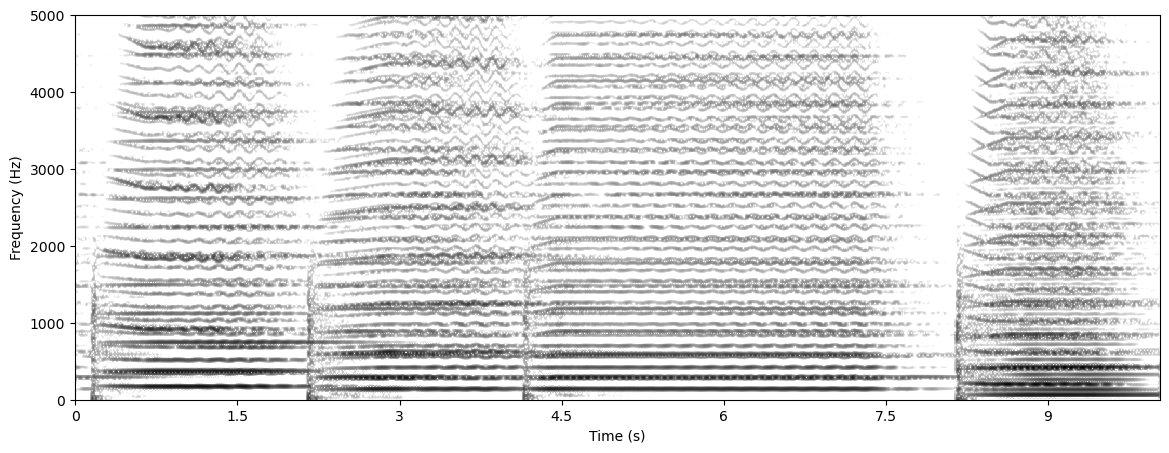

In [547]:
import numpy as np

# compute the spectrogram
D = librosa.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
S = np.abs(D)**2

# Time axis was off, so I had a little help from Librosa to fix it
x_coords = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=hop_length)

# plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.amplitude_to_db(S), 
                            x_coords=x_coords, 
                            x_axis='time', 
                            y_axis='hz',
                             sr=sr, 
                            cmap='gray_r')

# prettify plot
plt.ylim(0, 5000)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")


# 1.2

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


First of we do a sanity check to see if dimensions of spectogram and the FFT match.

In [535]:
print("Shape of Spectogram S: ", S.shape)
print("Shape of FFT D: ", D.shape)

Shape of Spectogram S:  (4097, 1004)
Shape of FFT D:  (4097, 1004)


Setting up $\Delta T$ and $\Delta F$.
Since window is 50 ms, and hop is 10 ms, we have 50 frames per second. Thus, each 5th window represent 100 ms.

> **NOTE:** Obviously, this calculation was off. When I took $\Delta T$ to be 10 seconds it looked almost identical to Bob's plot. It could be that the spectogram defaults to a centered window, but I am not sure. 

In [552]:
# Emperically assign the delta t
# Use annoying character to make it stand out
ΔT = 10

To get equally sized frequency-bands, we use linspace. We get 25 bands, each 170 Hz wide.

In [537]:
# Feels like a ineffective workaround
# but it works ¯\_(ツ)_/¯
segments = 25
ΔF = int(S.shape[0]/segments)

163

In [561]:
print("ΔF: {}, ΔT: {}".format(ΔF, ΔT))

ΔF: 163, ΔT: 10


We are going to plot the anchors with a scatter plot. `fs` is the frequency coordinates, and `ts` is the time coordinates. We use the formulas from the course litterature to convert them into frequency and time. Since we are MIR noobies, we also probed the web and found an [excellent answer](https://stackoverflow.com/questions/63350459/getting-the-frequencies-associated-with-stft-in-librosa) to help navigate indices in the spectogram.

The calculations we use are:

$$ S(m,k) = \frac{m*F_s}{N}$$ 

for each frequency coordinate $m$, and, for each time coordinate $k$:

$$ S(m,k) = \frac{k*H}{F_s}$$

where $H$ is the hop size (10ms), and $F_s$ is the sampling frequency (44.1kHz), $S$ is spectogram, and $N$ is the number of FFT bins ($2^{13}$).

In [553]:
# anchor coordinates stored in two seperate arrays
fs = [] # frequency
ts = [] # time

for f in range(0, S.shape[0], ΔF):
    for t in range(0, S.shape[1], ΔT):
        neighborhood = S[f:f+ΔF, t:t+ΔT]
        local_max_db = np.max(neighborhood)
        # x and y are the coordinates of the local max in current neighborhood
        x, y = np.where(neighborhood == local_max_db)
        # add the coordinates to the list with corresponding offset (f and t)
        # necessary (math) evil for transposing from x and y 
        # in spectogram, to frequency and time in the signal
        fs.extend((x + f) * sr / n_fft)
        ts.extend((y + t) * hop_length / sr)

Text(0, 0.5, 'Frequency (Hz)')

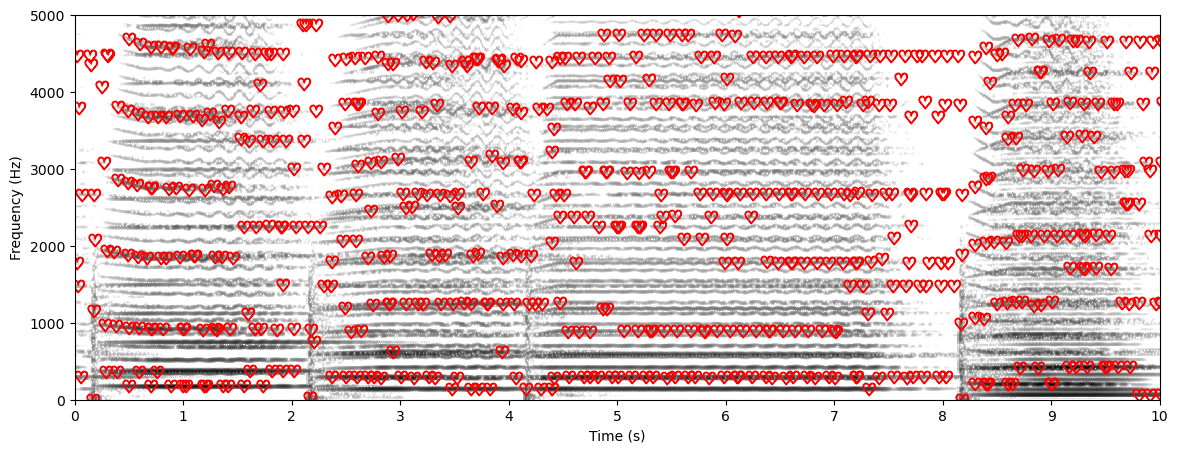

In [566]:
# plot the little specshow
plt.figure(figsize=(14, 5))

librosa.display.specshow(librosa.amplitude_to_db(S), 
                            x_axis='time', 
                            y_axis='hz',
                            x_coords=x_coords,
                            sr=sr, 
                            cmap='gray_r')

# superimpose scatterplot on the spectogram
plt.scatter(x = ts, y = fs, c='r', marker='$\heartsuit$', s=100)

# prettify plot
plt.ylim(0, 5000); plt.xlim(0, 10)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

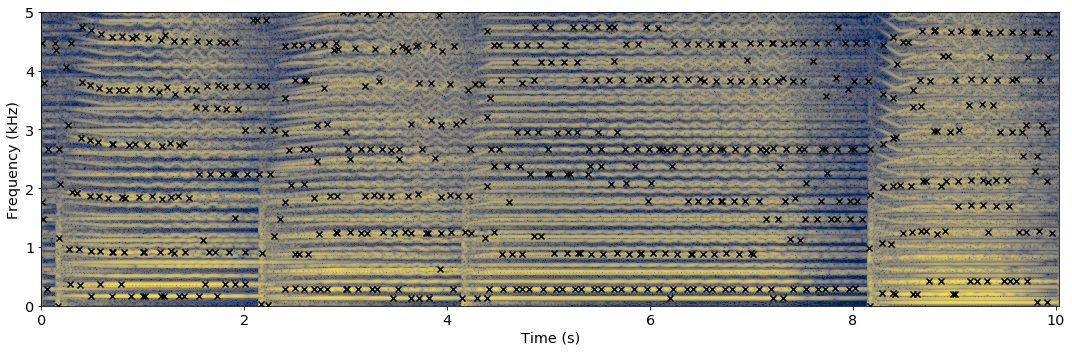

TODO: Write something intelligent about the results.

> *something intelligent*

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [4]:
# add your code below



# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

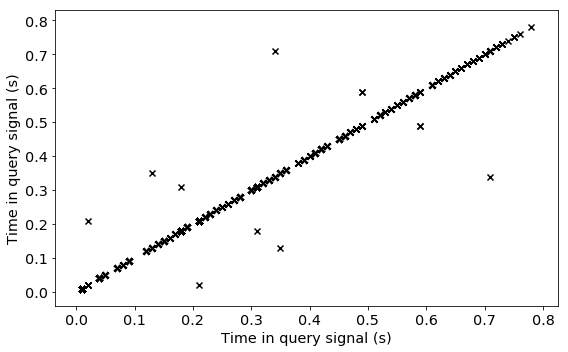



In [5]:
# add your code below



## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [7]:
# add your code below



## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

In [8]:
# add your code below



# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.